In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
import pointpats
import seaborn as sns
%matplotlib inline

#### Set directory

In [2]:
os.chdir("Data/")

In [3]:
def export_tif(ds, crs, path):

    import rasterio
    import rioxarray
    ds.rio.set_crs(crs, inplace=True)
    ds.rio.to_raster(path, driver='GTiff')
    
    x = ds['lon'].data
    y = ds['lat'].data
    src = rasterio.open(path)
    # get meta dict
    meta = src.meta

    # calculate pixel size
    pixel_size = np.diff(x).min()

    # add new affine
    meta['transform'] = rasterio.Affine(float(pixel_size), float(0.0), x.min(),
                    0.0, float(-pixel_size), float(y.max()))

    # export to tiff
    with rasterio.open(path, 'w', **meta) as raster:
        # If array is in  (y, x, z) order (cols, rows, bands)
        source = np.flip(src.read(), axis=1)
        raster.write(source)

In [4]:
def create_sets(ds, data, labels, buffer, y_index, x_index, features, dist=9.92, shuffle=True, specify=False, max_likelihood=0.5, use_only=False):
    
    from numpy import random, where, unique, concatenate, arange, ones, zeros
    
    set_array = np.empty((y_index.size, len(features)))

    for i in range(len(features)):
        set_array[:, i] = data[i][y_index, x_index]
        
        
    # positive locations' indexes
    labels = labels[y_index, x_index]
    pos_cond = (labels == 1) | (labels == 2)
    
    if use_only:
        pos_cond = labels == use_only
    pos_index = where(pos_cond)[0]
    
    # negative locations' indexes
    buffer_ = buffer[y_index, x_index]
    neg_index = random.choice(np.where(buffer_ > dist)[0], size=pos_index.size, replace=False)
    lat, lon = ds['lat'].data[y_index, x_index], ds['lon'].data[y_index, x_index]
    
    if specify:
        lat, lon = ds['lat'].data[y_index, x_index], ds['lon'].data[y_index, x_index]
        ny0, nx0 = unique(lat).size, unique(lon).size
        
        # negative locations' indexes
        spec_yx = where(ds[specify].data[y_index, x_index] == 0)[0]
        dist_yx = where(buffer.ravel() > dist)[0]
        neg_index = random.choice(np.intersect1d(spec_yx, dist_yx), size=pos_index.size, replace=False)
        
    
    # create sets
    pos_set = set_array[pos_index]
    neg_set = set_array[neg_index]
    
    # create labels
    pos_labels = ones(pos_index.size)
    neg_labels = zeros(neg_index.size)
    
    # concat
    X = concatenate((pos_set, neg_set))
    y = concatenate((pos_labels, neg_labels))
    
    if shuffle:
        idx = arange(y.size, dtype=int)
        random.shuffle(idx)
        
        X = X[idx]
        y = y[idx]
    
    
    return X, y, lat[neg_index], lon[neg_index]

### Importing dataset

In [5]:
dset = xarray.open_dataset('DATASETS/dset_AF_4.nc')
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 ...
    lat                    (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables: (12/20)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    pos_locations_buffer   (y, x) float64 ...
    litho_classes          (y, x) float32 ...
    idade_min              (y, x) float32 ...
    idade_max              (y, x) float32 ...
    Th_K                   (y, x) float64 ...
    U_K                    (y, x) float64 ...
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

### Predict multiple scenarios

In [6]:
variables = ['U_K', 'Th_K', 'DTM', 'dykes_buffer', 'lineam_wnw_ese_proxim', 'lineam_ne_sw_proxim']
print(variables)

['U_K', 'Th_K', 'DTM', 'dykes_buffer', 'lineam_wnw_ese_proxim', 'lineam_ne_sw_proxim']


In [7]:
# filter locations where lat > -10.15
train_idk, train_idj = np.where(dset['lat'].data > -10.15)
# filter locations where lat <= -10.15
test_idk, test_idj = np.where(dset['lat'].data <= -10.15)

In [8]:
ny0, nx0 = np.unique(dset['lat'].data[train_idk, train_idj]).size, np.unique(dset['lon'].data[train_idk, train_idj]).size
print((ny0, nx0))
ny1, nx1 = np.unique(dset['lat'].data[test_idk, test_idj]).size, np.unique(dset['lon'].data[test_idk, test_idj]).size
print((ny1, nx1))

(581, 1322)
(754, 1322)


In [9]:
data = np.array(dset[variables].to_array())
labels = dset['labels'].data
buffer = dset['pos_locations_buffer'].data

In [10]:
def stardardization(XX):
    N = XX.shape[1]
    for n in range(N):
        X = XX[:, n]
        XX[:, n] = (X - np.nanmean(X))/np.nanstd(X)
        
    return XX

In [11]:
# testset
data = np.array(dset[variables].to_array())
XX = np.zeros((test_idk.size, len(variables)))

for i in range(len(variables)):
    x = data[i][test_idk, test_idj]
    XX[:, i] = x

# stardardization
XX = stardardization(XX)

In [13]:
specify = 'fav_lithos'
X, y, lat_train, lon_train = create_sets(dset, data, labels, buffer, train_idk, train_idj,
                                                 variables, specify=specify, use_only=False)
X, y, lat_test, lon_test = create_sets(dset, data, labels, buffer, test_idk, test_idj,
                                                 variables, specify=specify, use_only=False)

In [14]:
# import positive examples
pos_gdf = gpd.read_file('VETORES/positive_loc.gpkg')

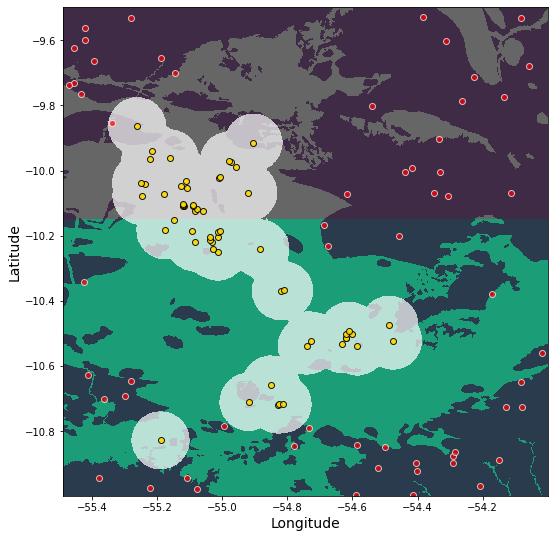

In [15]:
fig, ax = plt.subplots(figsize=(9, 9), facecolor='w')
train_test_area = np.where(dset['lat'].data > -10.15, 1, 0)
cat = np.where(dset['pos_locations_buffer'].data < 9.92, 1, np.nan)
ax.pcolormesh(dset['lon'].data, dset['lat'].data, train_test_area,
                   shading='auto', cmap='Dark2')
if specify:
    ax.pcolormesh(dset['lon'].data, dset['lat'].data, np.where(dset[specify].data == 0, 1, np.nan), 
                  shading='auto', cmap='turbo', alpha=0.7)
    
ax.pcolormesh(dset['lon'].data, dset['lat'].data, cat,
                   shading='auto', cmap='Greys', alpha=0.7)

pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.9)
ax.scatter(np.concatenate([lon_train, lon_test]), 
           np.concatenate([lat_train, lat_test]), color='r', edgecolor='w', alpha=.7)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_aspect(1)
#plt.legend(['positive examples', 'negative examples'])
#plt.savefig(f'figs/materials_methods/train_test_areas_spatial_criteria_{specify}_{c}.png', dpi=400, bbox_inches='tight')
# plt.savefig(f'figs/materials_methods/train_test_areas_spatial_criteria_{specify}.svg', format='svg', dpi=400, bbox_inches='tight')
plt.show()
c += 1

In [17]:
### Hyperparams to optimize

hparams = {}
# search best params - RF
hparams['rf'] = {'bootstrap':[False, True],
'criterion':['gini', 'entropy'],
 'max_depth': [2, 5, 10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [2, 3, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000]}

# search best params - svm
hparams['svm'] = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 'gamma':[0.01, 0.020, 0.05, 0.1, 0.2, 0.3,
                                                                 0.5, 0.7, 0.8, 0.9, 1, 2, 5], 'C':[0.1, 0.25, .5, 1, 1.5, 2, 2.5, 5, 7, 10]}


# search best params - knc
hparams['knc'] = {'n_neighbors':[7, 9, 10, 11, 12, 15, 16],
            'weights':['uniform', 'distance'],
            'algorithm':['auto'],
            'p':[1, 2]}

In [18]:
print('deposits in the train area:', np.where(labels[train_idk, train_idj] == 2)[0].size)
print('deposits in the test area:', np.where(labels[test_idk, test_idj] == 2)[0].size)

print('occurrences in the train area:', np.where(labels[train_idk, train_idj] == 1)[0].size)
print('occurrences in the test area:', np.where(labels[test_idk, test_idj] == 1)[0].size)

deposits in the train area: 6
deposits in the test area: 5
occurrences in the train area: 21
occurrences in the test area: 27


### Specify extra constraint for selecting negative examples

In [19]:
specify = 'fav_lithos'

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sys import stdout
from sklearn.neighbors import KNeighborsClassifier

mnames = 'rf svm knc'.split(' ')
models = {}

# set models
models['rf'] = RandomForestClassifier()
models['svm'] = svm.SVC()
models['knc'] = KNeighborsClassifier()

# best params
best_params = {}
#best scores
best_scores = {}


for m in tqdm(mnames):

    grid_search = RandomizedSearchCV(models[m], hparams[m], n_iter=100, cv=5, n_jobs =-1, 
                                     scoring='roc_auc', error_score=False, return_train_score=True, random_state=13)
    
    
    # test for different sets
    nsets = 5
    scores = []
    params = []
    estimators = []
    X_train = []
    y_train = []
    
    
    for n in range(nsets):
        X, y, _, _ = create_sets(dset, data, labels, buffer, train_idk, train_idj,
                                                 variables, specify=specify, use_only=2)
        X_train.append(X)
        y_train.append(y)
    
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_train = stardardization(X_train)
        
    # search best params
    search = grid_search.fit(X_train, y_train)
    params.append(search.best_params_)
    estimators.append(search.best_estimator_)
    scores.append(search.best_score_)
        
    percentage = (n+1)/nsets
    time_msg = "\rRunning Progress at {0:.2%} ".format(percentage)
    stdout.write(time_msg)
        
    # choose the best
    best_id = np.argmax(scores)
    best_scores[m] = np.max(scores)
    best_params[m] = params[best_id]
    models[m] = estimators[best_id]

  0%|          | 0/3 [00:00<?, ?it/s]

Running Progress at 100.00% 

/home/silva/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 28 is smaller than n_iter=100. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [22]:
import pickle
# save best params, scores, and models

with open(f'PICKLE/best_params_{specify}.pickle', 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'PICKLE/best_scores_{specify}.pickle', 'wb') as handle:
    pickle.dump(best_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'PICKLE/models_{specify}.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
### reset models

models['rf'] = RandomForestClassifier(n_estimators=best_params['rf']['n_estimators'],
                                min_samples_split=best_params['rf']['min_samples_split'],
                                min_samples_leaf=best_params['rf']['min_samples_leaf'],
                                max_features=best_params['rf']['max_features'], max_depth=best_params['rf']['max_depth'],
                                criterion=best_params['rf']['criterion'], bootstrap=best_params['rf']['bootstrap'],
                                      n_jobs=-1, random_state=0)

models['svm'] = svm.SVC(kernel=best_params['svm']['kernel'], gamma=best_params['svm']['gamma'], 
                C=best_params['svm']['C'],
                        probability=True, random_state=0)


models['knc'] = KNeighborsClassifier(n_neighbors=9,#best_params['knc']['n_neighbors'],
                                    weights=best_params['knc']['weights'],
                                    algorithm=best_params['knc']['algorithm'],
                                    p=best_params['knc']['p'], n_jobs=-1)

### F-Importances

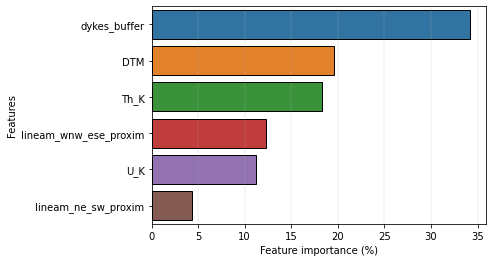

In [24]:
models['rf'].fit(X_train, y_train)
FI = models['rf'].feature_importances_
arg = np.argsort(models['rf'].feature_importances_)[::-1]
FI_dict = {'Features': np.array(variables)[arg], 'Feature importance (%)':FI[arg]*100}
FI_df = pd.DataFrame(FI_dict)

plt.figure(facecolor='w')
plt.grid(linewidth=0.2)
sns.barplot(y='Features', x='Feature importance (%)', data=FI_df, edgecolor='k')
plt.show()

### SHAPley

In [25]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [26]:
explainer = shap.TreeExplainer(models['rf'])
rf_shap_values = explainer.shap_values(X_train)

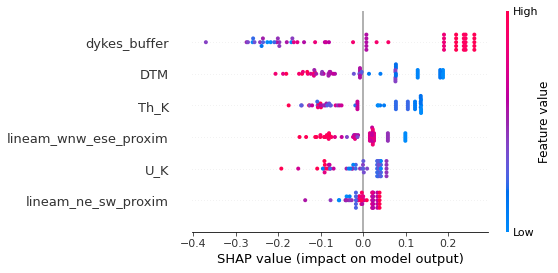

In [27]:
shap.summary_plot(rf_shap_values[1], X_train, variables)

### Quantification of Uncertainty

#### Scenarios

In [28]:
def compute_uncertainty(models, m, nreal, dset, variables, XX=XX, train_idk=train_idk, train_idj=train_idj,
                       test_idk=test_idk, test_idj=test_idj, specify=False):
    
    
    from sklearn.metrics import confusion_matrix, roc_auc_score
    from sys import stdout
    from numpy import array, where, mean
    import time
    import pickle
    
    auc = np.empty((nreal, 1))
    auc_dep = np.empty((nreal, 1))
    cfm = np.empty((nreal, 2, 2))
    cfm_dep = np.empty((nreal, 2, 2))
    probs = np.empty((nreal, ny1, nx1))
    FI = np.empty((nreal, len(variables)))
    
        
    
    tic = time.time()
    for real in range(nreal):
        
        # print
        percentage = real/nreal
        time_msg = "\rRunning Progress at {0:.2%} ".format(percentage)
        stdout.write(time_msg)
        
        X_train, y_train, _, _ = create_sets(dset, data, labels, buffer, train_idk, train_idj, variables, specify=specify, use_only=False)
        X_test_dep, y_test_dep, _, _ = create_sets(dset,data, labels, buffer, test_idk, test_idj, variables, specify=specify, use_only=2)
        X_test, y_test, _, _ = create_sets(dset, data, labels, buffer, test_idk, test_idj, variables,  specify=specify, use_only=1)
        
            
        # scaler
        X_train = stardardization(X_train)
        X_test = stardardization(X_test)
        X_test_dep = stardardization(X_test_dep)
        
        models[m].fit(X_train, y_train)
        y_pred = models[m].predict(X_test)
        y_pred_dep = models[m].predict(X_test_dep)
        auc[real] = roc_auc_score(y_test, y_pred), 
        auc_dep[real] = roc_auc_score(y_test_dep, y_pred_dep)
        cfm[real] = confusion_matrix(y_test, y_pred)
        cfm_dep[real] = confusion_matrix(y_test_dep, y_pred_dep)
        
        # print
        percentage = (0.5+real)/nreal
        time_msg = "\rRunning Progress at {0:.2%} ".format(percentage)
        stdout.write(time_msg)
         
        
        # feature importances            
        if(m == 'rf'):
            FI[real] = models[m].feature_importances_

        else:                      
            # calculate shapley values
            explainer = shap.KernelExplainer(models[m].predict, X_train)
            shap_values = explainer.shap_values(X_train, silent=True)

            # positive samples
            pos_index = where(y_train == 1.)[0]
            avg_pos_impact = mean(shap_values[pos_index], axis=0)
            FI[real] = avg_pos_impact/np.sum(avg_pos_impact)            

        
        # predicting classes' probabilities
        prob = models[m].predict_proba(XX)
        prob = array(prob[:, 1])
        probs[real] = prob.reshape(ny1, nx1)
        
        # print
        percentage = (1+real)/nreal
        time_msg = "\rRunning Progress at {0:.2%} ".format(percentage)
        stdout.write(time_msg)
                      
    toc = time.time()
    tm = (toc-tic)/60.
    
    
    # save it to pickle
    with open(f'PICKLE/{m}_aucs_{specify}.pickle', 'wb') as handle:
        pickle.dump(auc, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open(f'PICKLE/{m}_cfms_{specify}.pickle', 'wb') as handle:
        pickle.dump(cfm, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'PICKLE/{m}_FIs_{specify}.pickle', 'wb') as handle:
        pickle.dump(FI, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open(f'PICKLE/{m}_probs_{specify}.pickle', 'wb') as handle:
        pickle.dump(probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
    return auc, auc_dep, cfm, cfm_dep, probs, FI, tm

In [29]:
# store metrics and other outputs
aucs = {}
aucs_dep = {}
cfms = {}
cfms_dep = {}
FIs = {}
probs = {}
times = []

In [30]:
# number of realizations
nreal = 200
for m in tqdm(mnames):
    print(f'model: {m}')
    auc, auc_dep, cfm, cfm_dep, prob, FI, tm = compute_uncertainty(models, m, nreal, dset, variables, specify=specify)

    aucs[m] = auc
    aucs_dep[m] = auc_dep
    cfms[m] = cfm
    cfms_dep[m] = cfm_dep
    probs[m] = prob
    FIs[m] = FI
    times.append(tm)
    print('\n')

  0%|          | 0/3 [00:00<?, ?it/s]

model: rf
Running Progress at 100.00% 

model: svm
Running Progress at 100.00% 

model: knc
Running Progress at 100.00% 



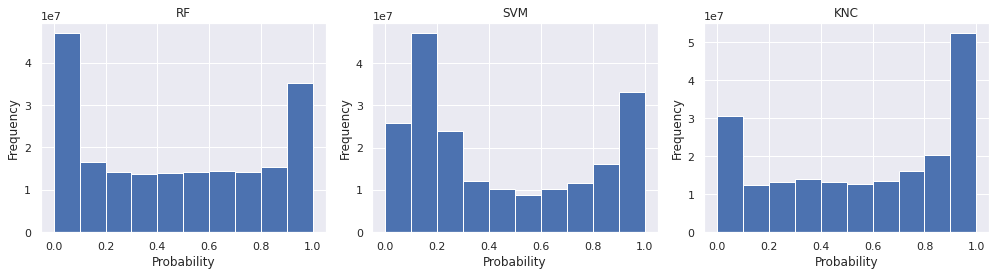

In [31]:
import seaborn as sns
sns.set_theme()
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
ax[0].hist(probs['rf'].ravel())
ax[1].hist(probs['svm'].ravel())
ax[2].hist(probs['knc'].ravel())
ax[0].set_title('RF'); ax[1].set_title('SVM'); ax[2].set_title('KNC')
ax[0].set_xlabel('Probability'); ax[1].set_xlabel('Probability'); ax[2].set_xlabel('Probability')
ax[0].set_ylabel('Frequency'); ax[1].set_ylabel('Frequency'); ax[2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [32]:
for n, m in enumerate(mnames):
    print(f'{m}: {times[n]:.4f} min')

rf: 0.5763 min
svm: 0.5929 min
knc: 0.5764 min


In [33]:
for n, m in enumerate(mnames):
    p = probs[m]
    print(f'prospective area - {m}:{(p[p > 0.9].size/p.size):.3f}')

prospective area - rf:0.177
prospective area - svm:0.166
prospective area - knc:0.264


In [34]:
# save it to pickle
with open(f'PICKLE/final_aucs_{specify}.pickle', 'wb') as handle:
    pickle.dump(aucs, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'PICKLE/final_aucs_dep_{specify}.pickle', 'wb') as handle:
    pickle.dump(aucs_dep, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'PICKLE/final_cfms_{specify}.pickle', 'wb') as handle:
    pickle.dump(cfms, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'PICKLE/final_cfms_dep_{specify}.pickle', 'wb') as handle:
    pickle.dump(cfms_dep, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'PICKLE/final_FIs_{specify}.pickle', 'wb') as handle:
    pickle.dump(FIs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'PICKLE/final_probs_{specify}.pickle', 'wb') as handle:
    pickle.dump(probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'PICKLE/comp_time_{specify}.pickle', 'wb') as handle:
    pickle.dump(times, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/3 [00:00<?, ?it/s]

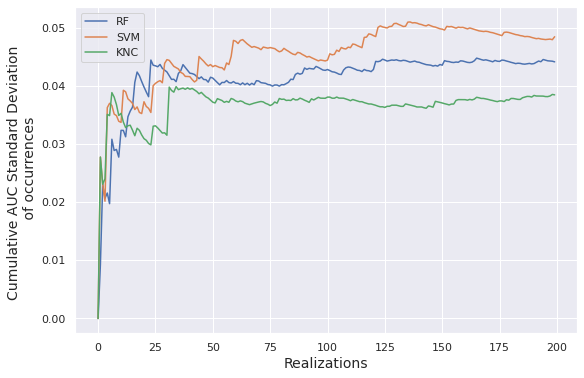

  0%|          | 0/3 [00:00<?, ?it/s]

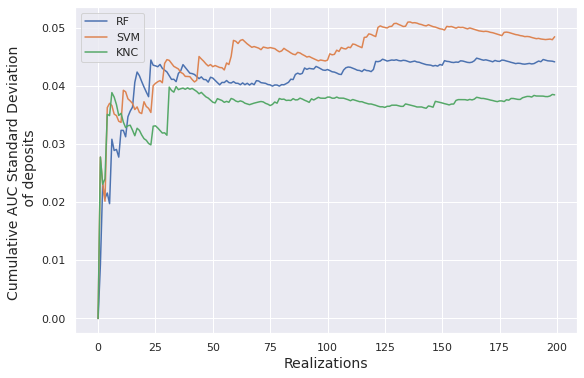

  0%|          | 0/3 [00:00<?, ?it/s]

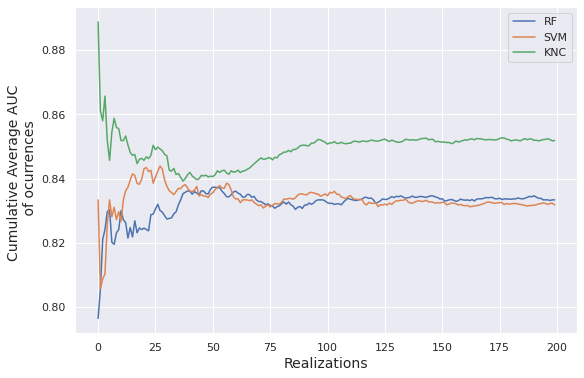

  0%|          | 0/3 [00:00<?, ?it/s]

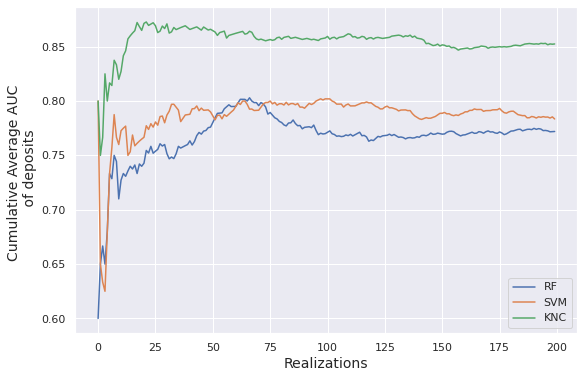

In [35]:
# calculate cumulative property

def calc_c(array, func=np.var):
    # store cumulative values
    c = []
    for i in range(1, array.size+1):
        c.append(func(array[:i]))
    c = np.array(c)

    return c

sns.set_style()

plt.figure(figsize=(9, 6))
for m in tqdm(mnames):
    plt.plot(np.arange(aucs[m].size), calc_c(aucs[m], np.std))
plt.ylabel('Cumulative AUC Standard Deviation \n of occurrences', fontsize=14)
plt.xlabel('Realizations', fontsize=14)
plt.legend([n.upper() for n in mnames])
plt.grid(True)
plt.savefig(f'figs/cumul_auc_std_occ_{specify}.png', dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(9, 6))
for m in tqdm(mnames):
    plt.plot(np.arange(aucs_dep[m].size), calc_c(aucs[m], np.std))
plt.ylabel('Cumulative AUC Standard Deviation \n of deposits', fontsize=14)
plt.xlabel('Realizations', fontsize=14)
plt.legend([n.upper() for n in mnames])
plt.grid(True)
plt.savefig(f'figs/cumul_auc_std_dep_{specify}.png', dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(9, 6))
for m in tqdm(mnames):
    plt.plot(np.arange(aucs[m].size), calc_c(aucs[m], np.mean))
plt.ylabel('Cumulative Average AUC \n of ocurrences', fontsize=14)
plt.xlabel('Realizations', fontsize=14)
plt.legend([n.upper() for n in mnames])
plt.grid(True)
plt.savefig(f'figs/cumul_auc_mean_occ_{specify}.png', dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(9, 6))
for m in tqdm(mnames):
    plt.plot(np.arange(aucs_dep[m].size), calc_c(aucs_dep[m], np.mean))
plt.ylabel('Cumulative Average AUC \n of deposits', fontsize=14)
plt.xlabel('Realizations', fontsize=14)
plt.legend([n.upper() for n in mnames])
plt.grid(True)
plt.savefig(f'figs/cumul_auc_mean_dep_{specify}.png', dpi=400, bbox_inches='tight')
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

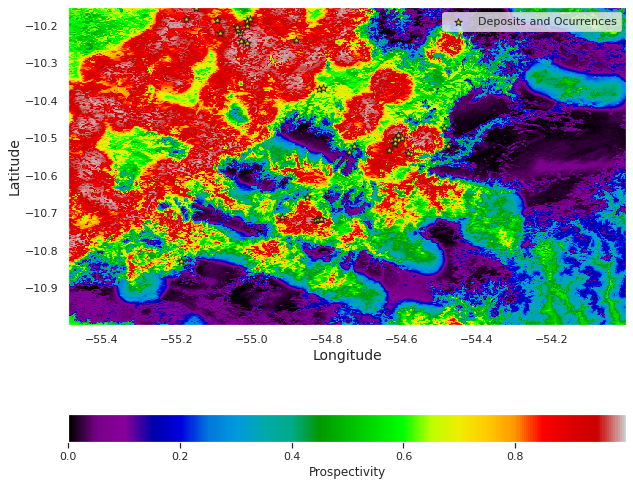

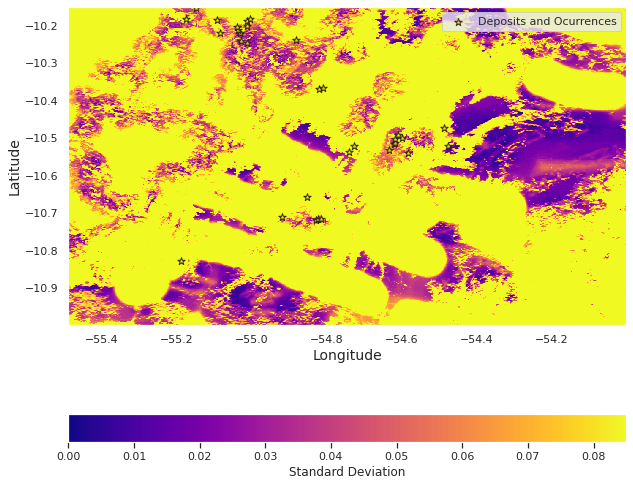

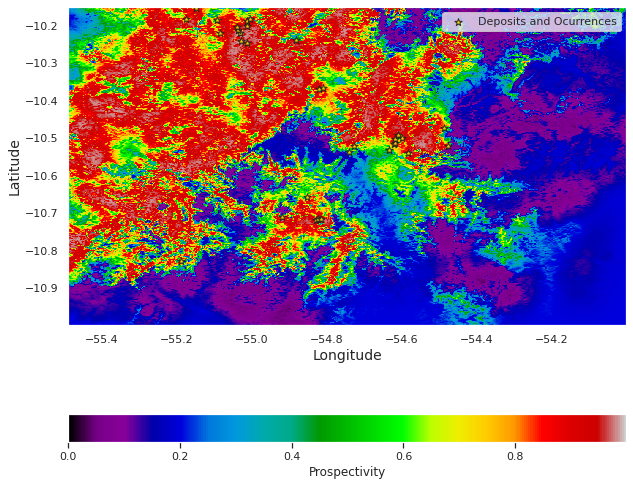

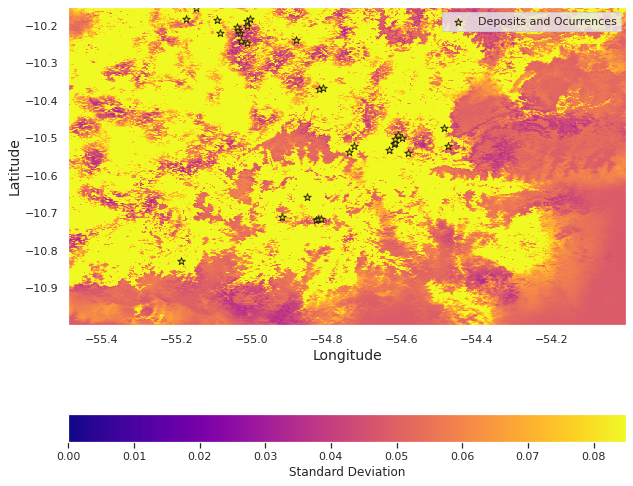

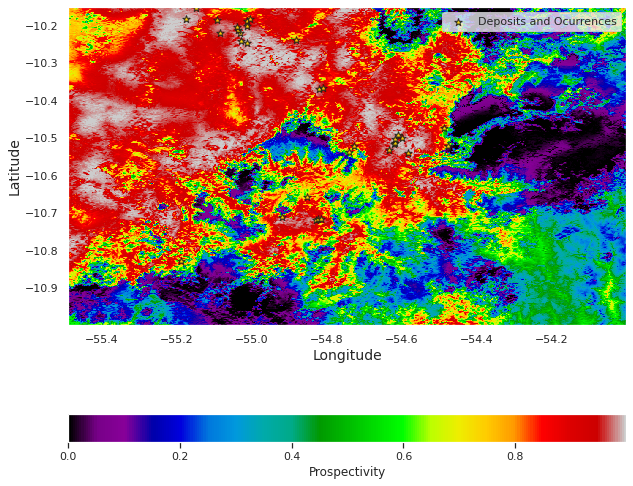

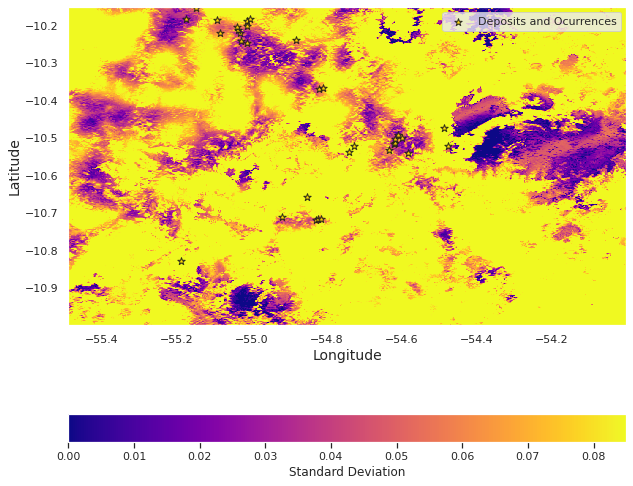

In [36]:
sns.set_theme()
lon = dset['lon'].data[test_idk, test_idj].reshape(ny1, nx1)
lat = dset['lat'].data[test_idk, test_idj].reshape(ny1, nx1)


for m in tqdm(mnames):
    # calc mean of predictions
    prob_mean = np.mean(probs[m], axis=0)
    # calc std of predictions
    prob_std = np.std(probs[m], axis=0)
    
    plt.rcParams['axes.grid'] = False
    fig, ax = plt.subplots(figsize=(10, 11), facecolor='w')
    im = ax.pcolormesh(lon, lat, prob_mean,
                       shading='auto', cmap='nipy_spectral', vmin=0., vmax=0.999)
    pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.9, label='Deposits and Ocurrences', marker='*', markersize=60)
    plt.colorbar(im, ax=ax, label='Prospectivity', orientation='horizontal')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_xlim(lon.min(), lon.max())
    ax.set_ylim(lat.min(), lat.max())
    ax.set_aspect(1)
    plt.legend()
    plt.savefig(f'figs/{m}/mean_mpm_gold_{m}_{specify}.png', dpi=400, bbox_inches='tight')
    
    fig, ax = plt.subplots(figsize=(10, 11), facecolor='w')
    im = ax.pcolormesh(lon, lat, prob_std, shading='auto', vmin=0.0, vmax=0.085, cmap='plasma')
    pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.9, label='Deposits and Ocurrences', marker='*', markersize=60)
    plt.colorbar(im, ax=ax, label='Standard Deviation', orientation='horizontal')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_xlim(lon.min(), lon.max())
    ax.set_ylim(lat.min(), lat.max())
    ax.set_aspect(1)
    plt.legend()
    plt.savefig(f'figs/{m}/std_mpm_gold_{m}_{specify}.png', dpi=400, bbox_inches='tight')
    plt.show()

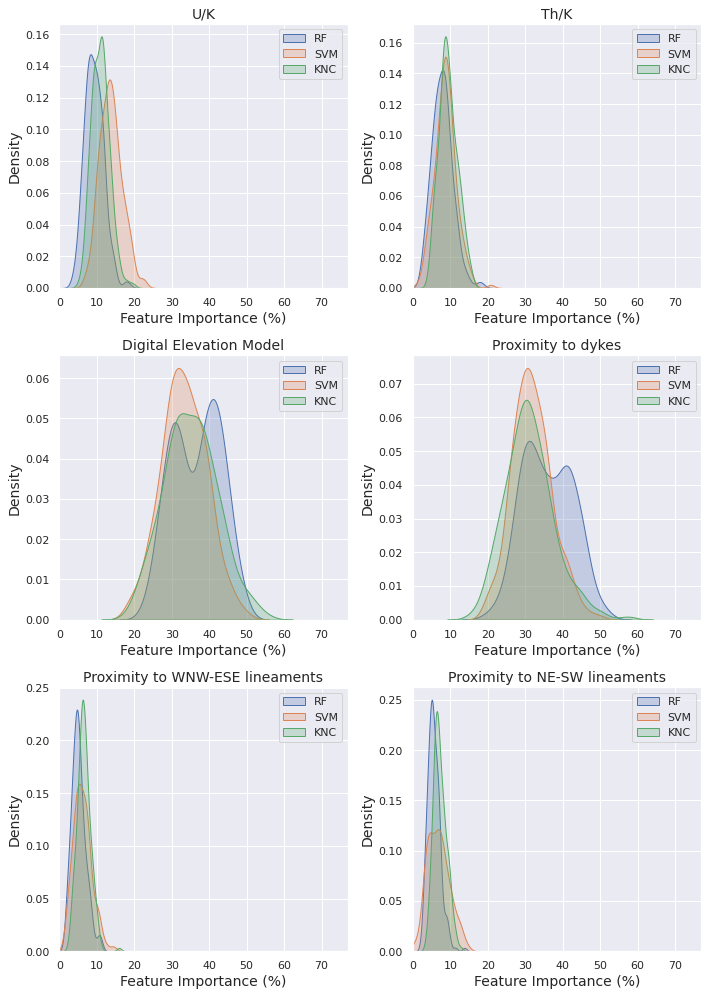

In [37]:
sns.set_theme()
from numpy import where

fnames = ['U/K', 'Th/K', 'Digital Elevation Model', 'Proximity to dykes',
            'Proximity to WNW-ESE lineaments', 'Proximity to NE-SW lineaments']


# FI = np.hstack(FIs[m]*100)
# labels = np.tile(variables, nreal)
# df = pd.DataFrame({'Feature importances (%)':FI, 'Feature':labels})

stacked_FIs = np.vstack((FIs['rf'], FIs['svm'],  FIs['knc']))
stacked_FIs = where(stacked_FIs < 0, 0, stacked_FIs)
FI_mean = np.mean(stacked_FIs, axis=0)
FI_min = np.min(stacked_FIs, axis=0)
FI_max = np.max(stacked_FIs, axis=0)

# dfs
FI_mean_df = pd.DataFrame({'Features':fnames,'Feature importances (%)':FI_mean*100})
FI_min_df = pd.DataFrame({'Features':fnames, 'Feature importances (%)':FI_min*100})
FI_max_df = pd.DataFrame({'Features':fnames, 'Feature importances (%)':FI_max*100})


fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 14))
ax = axes.flatten()

c = 0
for i, f in enumerate(fnames):
    if i != 7:
        sns.kdeplot(FIs[mnames[0]][:, i]*100, shade=True, ax=ax[i], label='RF')
        sns.kdeplot(FIs[mnames[1]][:, i]*100, shade=True, ax=ax[i], label='SVM')
        sns.kdeplot(FIs[mnames[2]][:, i]*100, shade=True, ax=ax[i], label='KNC')
        ax[i].set_xlim(-0.1, 77.)
        ax[i].set_xlabel('Feature Importance (%)', fontsize=14)
        ax[i].set_ylabel('Density', fontsize=14)
        ax[i].set_title(f, fontsize=14)
        ax[i].legend()
    
    
# sns.barplot(y='Features', x='Feature importances (%)', data=FI_max_df, edgecolor='k', 
#             color='aqua', label='max', ax=ax[-1], alpha=0.8)
    
# sns.barplot(y='Features', x='Feature importances (%)', data=FI_mean_df, edgecolor='k',
#             color='orange', label='mean', ax=ax[-1], alpha=0.8)
# sns.barplot(y='Features', x='Feature importances (%)' , data=FI_min_df, edgecolor='k', 
#             color='teal', label='min', ax=ax[-1], alpha=0.8)

# ax[-1].legend()
# ax[-1].set_xlim(-0.5, 79.)
# ax[-1].set_xlabel('Feature Importance (%)', fontsize=14)     
# ax[-1].set_ylabel(' ') 
# ax[-1].set_title('Statistics', fontsize=14)
plt.tight_layout()
fig.savefig(f'figs/kdes_feature_importances_{specify}.png', dpi=400, bbox_inches='tight')
fig.savefig(f'figs/kdes_feature_importances_{specify}.svg', format='svg', dpi=400, bbox_inches='tight')

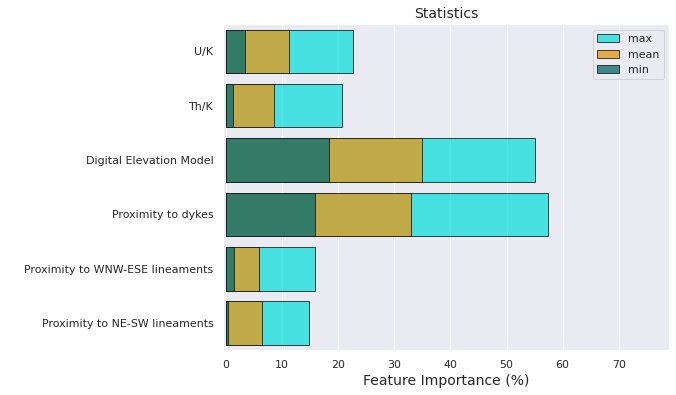

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(y='Features', x='Feature importances (%)', data=FI_max_df, edgecolor='k', 
            color='aqua', label='max', ax=ax, alpha=0.8)
    
sns.barplot(y='Features', x='Feature importances (%)', data=FI_mean_df, edgecolor='k',
            color='orange', label='mean', ax=ax, alpha=0.8)
sns.barplot(y='Features', x='Feature importances (%)' , data=FI_min_df, edgecolor='k', 
            color='teal', label='min', ax=ax, alpha=0.8)

ax.legend()
ax.set_xlim(-0.5, 79.)
ax.set_xlabel('Feature Importance (%)', fontsize=14)     
ax.set_ylabel(' ') 
ax.set_title('Statistics', fontsize=14)
fig.savefig(f'figs/stats_feature_importances_{specify}.png', dpi=400, bbox_inches='tight')
fig.savefig(f'figs/stats_feature_importances_{specify}.svg', format='svg', dpi=400, bbox_inches='tight')

### Confusion Matrix

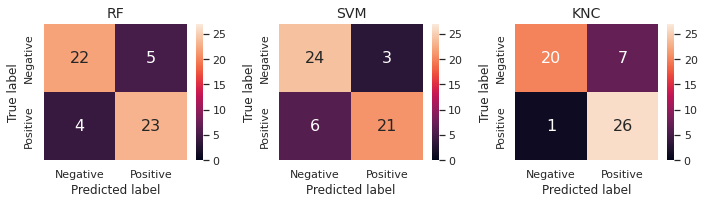

In [39]:
import seaborn as sns
from scipy.stats import mode
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 3))
axes = axes.flatten()

for m, ax in zip(mnames, axes):
    sns.heatmap(mode(cfms[m], axis=0)[0][0], annot=True, ax=ax, yticklabels=['Negative', 'Positive'],
               xticklabels=['Negative', 'Positive'], annot_kws={"size": 16}, vmin=0, vmax=np.sum(cfms[m][0])//2)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_title(f'{m.upper()}', fontsize=14)
plt.tight_layout()
plt.savefig(f'figs/confusion_matrices_occ_{specify}.png', dpi=400, bbox_inches='tight')
plt.savefig(f'figs/confusion_matrices_occ_{specify}.svg', format='svg', dpi=400, bbox_inches='tight')
plt.show()

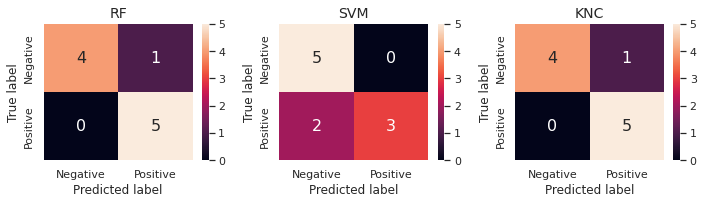

In [40]:
import seaborn as sns
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 3))
axes = axes.flatten()

for m, ax in zip(mnames, axes):
    sns.heatmap(mode(cfms_dep[m], axis=0)[0][0], annot=True, ax=ax, yticklabels=['Negative', 'Positive'],
               xticklabels=['Negative', 'Positive'], annot_kws={"size": 16}, vmin=0, vmax=np.sum(cfms_dep[m][0])//2)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_title(f'{m.upper()}', fontsize=14)
plt.tight_layout()
plt.savefig(f'figs/confusion_matrices_dep_{specify}.png', dpi=400, bbox_inches='tight')
plt.savefig(f'figs/confusion_matrices_dep_{specify}.svg', format='svg', dpi=400, bbox_inches='tight')
plt.show()